# Alignment & stacking

Image stacking combines multiple exposures of the same field of view to significantly improve signal-to-noise ratio. Since signal accumulates linearly while noise grows only with the square root of the number of frames, stacking allows astronomers to reveal faint details invisible in single exposures.

Before stacking can occur, precise alignment is essential. Even with quality equipment, images shift between frames due to atmospheric conditions, mount imperfections, and Earth's rotation. Alignment algorithms identify reference stars in order to apply transformations to register each image to a common reference frame with sub-pixel accuracy. This is the case of the [Lang 2010]() algorithm, that we will use through its implementation in [twirl](https://github.com/lgrcia/twirl).

In this tutorial, we will align and stack the science images from [photometry dataset](datasets). We will start from the calibrated images produced in the [calibration tutorial](calibration).

In [1]:
from glob import glob

images = glob("calibrated_images/*.fits")

Although it is not absolutely necessary, it is always a good idea to have the files sorted by date.

In [2]:
from astropy.io import fits
from dateutil import parser


def observation_time(file):
    date_str = fits.getheader(file)["DATE-OBS"]
    return parser.parse(date_str)


# order by observation time
images = sorted(images, key=lambda file: observation_time(file))

## Alignment

We will now align all images to a reference image. We choose our reference to be an image taken roughly in the middle of the complete observation

In [3]:
reference = images[0]

Let's now create a small function to detect stars in an image. These stars will be used in order to compute the transform from one image to another

In [4]:
import numpy as np
from astropy.io import fits
from eloy import detection


def detect_stars_coords(data):
    regions = detection.stars_detection(data)
    # stars coords and cutouts
    region_coords = np.array(
        [(r.centroid_weighted[1], r.centroid_weighted[0]) for r in regions]
    )

    return region_coords

This is the result of this function applied to our reference

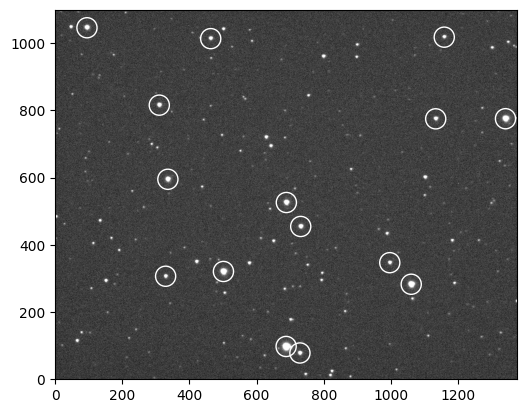

In [5]:
import matplotlib.pyplot as plt
from eloy import viz

reference_coords = detect_stars_coords(fits.getdata(reference))[0:15]

plt.imshow(viz.z_scale(fits.getdata(reference)), cmap="Greys_r", origin="lower")
viz.plot_marks(*reference_coords.T, color="w", ms=30)

Given two sets of coordinates [alignment.rotation_matrix](eloy.alignment.rotation_matrix) computes the matrix that transforms one set to another. Using this matrix, we can apply the transform to the entire image so the images from which we detected these two sets are aligned. Let's put that in a function.

In [6]:
from skimage.transform import warp
from eloy import alignment

ref_reference = alignment.twirl_reference(reference_coords)


def wrap_data(data):
    coords = detect_stars_coords(data)[0:15]
    X = alignment.rotation_matrix(coords, reference_coords, ref_reference)
    wrapped_data = warp(data.astype(float), X)
    return wrapped_data

Let's show how two images get aligned

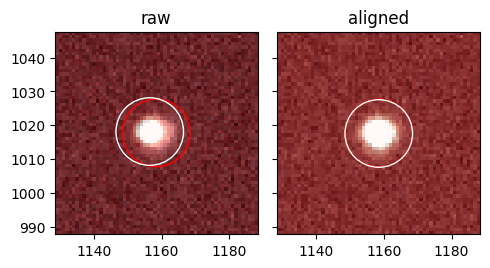

In [7]:
import matplotlib.pyplot as plt
from eloy import viz

fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

ref_data = fits.getdata(reference)
image_data = fits.getdata(images[-1])
imade_data_tr = wrap_data(image_data)

axes[0].imshow(viz.z_scale(ref_data), cmap="Greys_r", origin="lower")
viz.plot_marks(*detect_stars_coords(ref_data).T, color="red", ms=10, ax=axes[0])
axes[0].imshow(viz.z_scale(image_data), cmap="Reds_r", origin="lower", alpha=0.5)
viz.plot_marks(*detect_stars_coords(image_data).T, color="w", ms=10, ax=axes[0])
axes[0].set_title("raw")

axes[1].imshow(viz.z_scale(ref_data), cmap="Greys_r", origin="lower")
viz.plot_marks(*detect_stars_coords(ref_data).T, color="red", ms=10, ax=axes[1])
axes[1].imshow(viz.z_scale(imade_data_tr), cmap="Reds_r", origin="lower", alpha=0.5)
viz.plot_marks(*detect_stars_coords(imade_data_tr).T, color="w", ms=10, ax=axes[1])
axes[1].set_title("aligned")

control_coords = reference_coords[-1]
plt.xlim(*(control_coords[0] + 30 * np.array([-1, 1])))
plt.ylim(*(control_coords[1] + 30 * np.array([-1, 1])))
plt.tight_layout()

In this figure the reference image (grey) and the image to align (red) are transparently shown on top of each other together with the stars detected in the image. As we can see, applying the transformation does lead to the target image and its stars being aligned to the reference!

## Stack image

We can now stack images together. Here we simply sum all the aligned images

In [8]:
from tqdm.auto import tqdm

stack_image = np.zeros_like(fits.getdata(reference))

for image in tqdm(images):
    aligned_image = wrap_data(fits.getdata(image))
    stack_image += aligned_image

  0%|          | 0/336 [00:00<?, ?it/s]

Let's show the resulting stack image next to our reference image

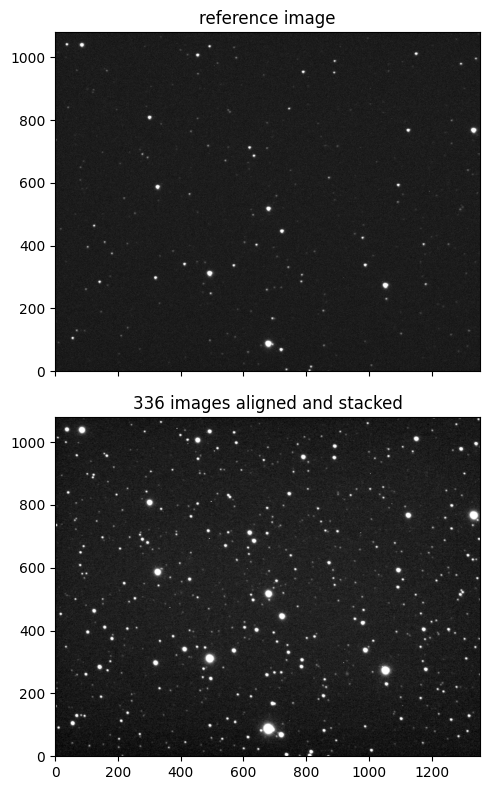

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True, sharey=True)
axes[0].imshow(viz.z_scale(ref_data[10:-10, 10:-10]), cmap="Greys_r", origin="lower")
axes[0].set_title("reference image")
axes[1].imshow(viz.z_scale(stack_image[10:-10, 10:-10]), cmap="Greys_r", origin="lower")
axes[1].set_title(f"{len(images)} images aligned and stacked")
plt.tight_layout()

As expected, we greatly improved the signal-to-noise ratio. Let's save this image for a future use.

In [10]:
hdu = fits.PrimaryHDU(data=stack_image, header=fits.getheader(reference))
filename = "calibrated_images/stack_image.fits"
hdu.writeto(filename, overwrite=True)